### DOMAIN:
Telecom
### CONTEXT: 
This project aims to predict if the client could churn based on their plans and contract information. If we discover that a user plans to leave, they will be offered promotional codes and special plan options. 
### DATA DESCRIPTION: 
Mainly we have two types of services: 
- Landline communication (several lines simultaneously are possible)
- Internet (DSL, *digital subscriber line*) or through a fiber optic cable.

And some additional internet services:
- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**FILES**
- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.
### PROJECT OBJECTIVE: 
Train a classifier to predict possible churning.   
Target feature: the `'EndDate'` column equals `'No'`. 

Primary metric: AUC-ROC.  
Additional metric: Accuracy.  

## Initialization

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from category_encoders import BinaryEncoder, OrdinalEncoder
from catboost import CatBoostClassifier, Pool

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

## Load Data
### Contracts

In [4]:
contract_dates = ['BeginDate']

try:
    contracts = pd.read_csv('./datasets/final_provider/contract.csv', parse_dates=contract_dates )
except:
    contracts = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=contract_dates)

contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


We have 11 contracts with `BeginDate` of 2020-02-01 (our final date), so they haven't any charges yet. We could drop them or set them to zero to convert the `TotalCharges` to float.

In [5]:
contracts.loc[contracts['TotalCharges']==' ', 'TotalCharges'] = 0
contracts['TotalCharges'] = pd.to_numeric(contracts['TotalCharges'])

contracts.info()
display(contracts.describe(include='all'))
display(contracts.head())
print(f'Duplicates in data: {contracts.duplicated().sum()} ({(contracts.duplicated().sum() / contracts.shape[0]):.2%})')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000,7043.000
unique,7043,77,5,3,2,4,NaN,NaN
top,7590-VHVEG,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,366,5174,3875,4171,2365,NaN,NaN
first,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.762,2279.734
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090,2266.794
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250,0.000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500,398.550


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.850
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.500
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.150
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.750
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.650


Duplicates in data: 0 (0.00%)


### Personal

In [6]:
try:
    personal = pd.read_csv('./datasets/final_provider/personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.rename(columns={"gender": "Gender"}, inplace = True)
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
# let's convert SeniorCitizen to Yes/No as all other categories
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('str')
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({'0':'No', '1':'Yes'})

display(personal.describe(include='all'))
display(personal.head())

print(f'Duplicates in data: {personal.duplicated().sum()} ({(personal.duplicated().sum() / personal.shape[0]):.2%})')

,customerID,Gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,No,No,No
freq,1,3555,5901,3641,4933


,customerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


Duplicates in data: 0 (0.00%)


### Internet

In [8]:
try:
    internet = pd.read_csv('./datasets/final_provider/internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
display(internet.describe(include='all'))
display(internet.head())
print(f'Duplicates in data: {internet.duplicated().sum()} ({(internet.duplicated().sum() / internet.shape[0]):.2%})')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Duplicates in data: 0 (0.00%)


### Phone

In [10]:
try:
    phone = pd.read_csv('./datasets/final_provider/phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [11]:
display(phone.describe(include='all'))
display(phone.head())
print(f'Duplicates in data: {phone.duplicated().sum()} ({(phone.duplicated().sum() / phone.shape[0]):.2%})')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Duplicates in data: 0 (0.00%)


In [12]:
contracts_joined = contracts.merge(personal, on='customerID', how='left')\
                            .merge(internet, on='customerID', how='left')\
                            .merge(phone, on='customerID', how='left')
contracts_joined.info()
contracts_joined.head().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
BeginDate,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00
EndDate,No,No,2019-12-01 00:00:00,No,2019-11-01 00:00:00
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
MonthlyCharges,29.850,56.950,53.850,42.300,70.700
TotalCharges,29.850,1889.500,108.150,1840.750,151.650
Gender,Female,Male,Male,Male,Female
SeniorCitizen,No,No,No,No,No


In [13]:
contracts_joined.fillna(value='n/a', inplace=True)

categs = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', \
          'Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
          'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for categ in categs:
    contracts_joined[categ] = contracts_joined[categ].astype('category')

contracts_joined.info()
contracts_joined.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Gender            7043 non-null   category      
 9   SeniorCitizen     7043 non-null   category      
 10  Partner           7043 non-null   category      
 11  Dependents        7043 non-null   category      
 12  InternetService   7043 non-null   category      
 13  OnlineSecurity    7043 non-null   category      
 14  OnlineBackup      7043 n

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01 00:00:00,366,2013-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.000,NaN,NaN,NaN,NaT,NaT,64.762,30.090,18.250,35.500,70.350,89.850,118.750
TotalCharges,7043.000,NaN,NaN,NaN,NaT,NaT,2279.734,2266.794,0.000,398.550,1394.550,3786.600,8684.800
Gender,7043,2,Male,3555,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,2,No,5901,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusion**  
Here we have some data on customers' contracts, their personal info, and connected services. We didn't have any duplicates or missing values. However, we have 11 fresh customers whose data we need to adjust. Because not all customers use both landline and internet services after merging all this information in one dataframe, we've got some missing values. They represent non-applicable services and could be replaced with some placeholder. 

## EDA

In [14]:
# let's extract from the `EndDate` a clear target (yes/no)
contracts_joined['Churned'] = 'Yes'
contracts_joined.loc[contracts_joined['EndDate']=='No', 'Churned'] = 'No'

# we don't have any real contracts with the EndDate of 2020-02-01, 
# so we could set it as an EndDate for not churned customers and calculate the tenure of the contracts
contracts_joined.loc[contracts_joined['EndDate']=='No', 'EndDate'] = '2020-02-01'
contracts_joined['EndDate'] = pd.to_datetime(contracts_joined['EndDate'])
contracts_joined['Tenure'] = contracts_joined['EndDate'] - contracts_joined['BeginDate']
contracts_joined['Tenure'] = contracts_joined['Tenure'].astype('timedelta64[D]')

churned = contracts_joined[contracts_joined['Churned']=='Yes']
notchurned = contracts_joined[contracts_joined['Churned']=='No']

contracts_joined['Churned'].value_counts()/contracts_joined.shape[0]

No    0.735
Yes   0.265
Name: Churned, dtype: float64

Churned customers


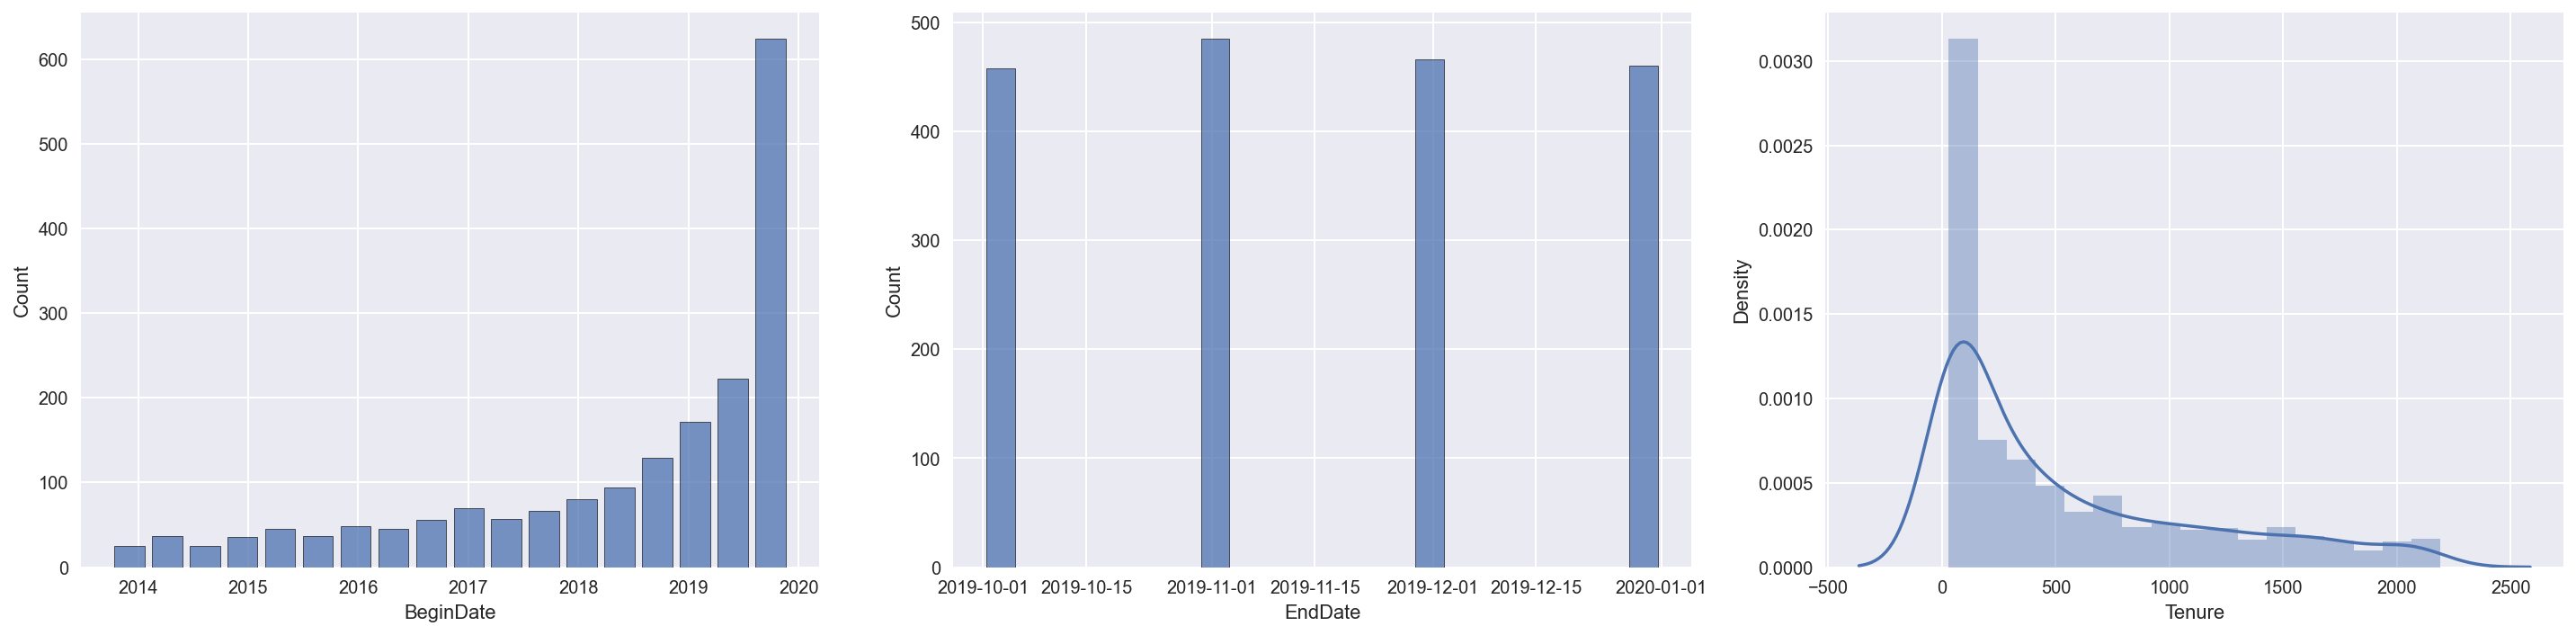


Non-churned customers


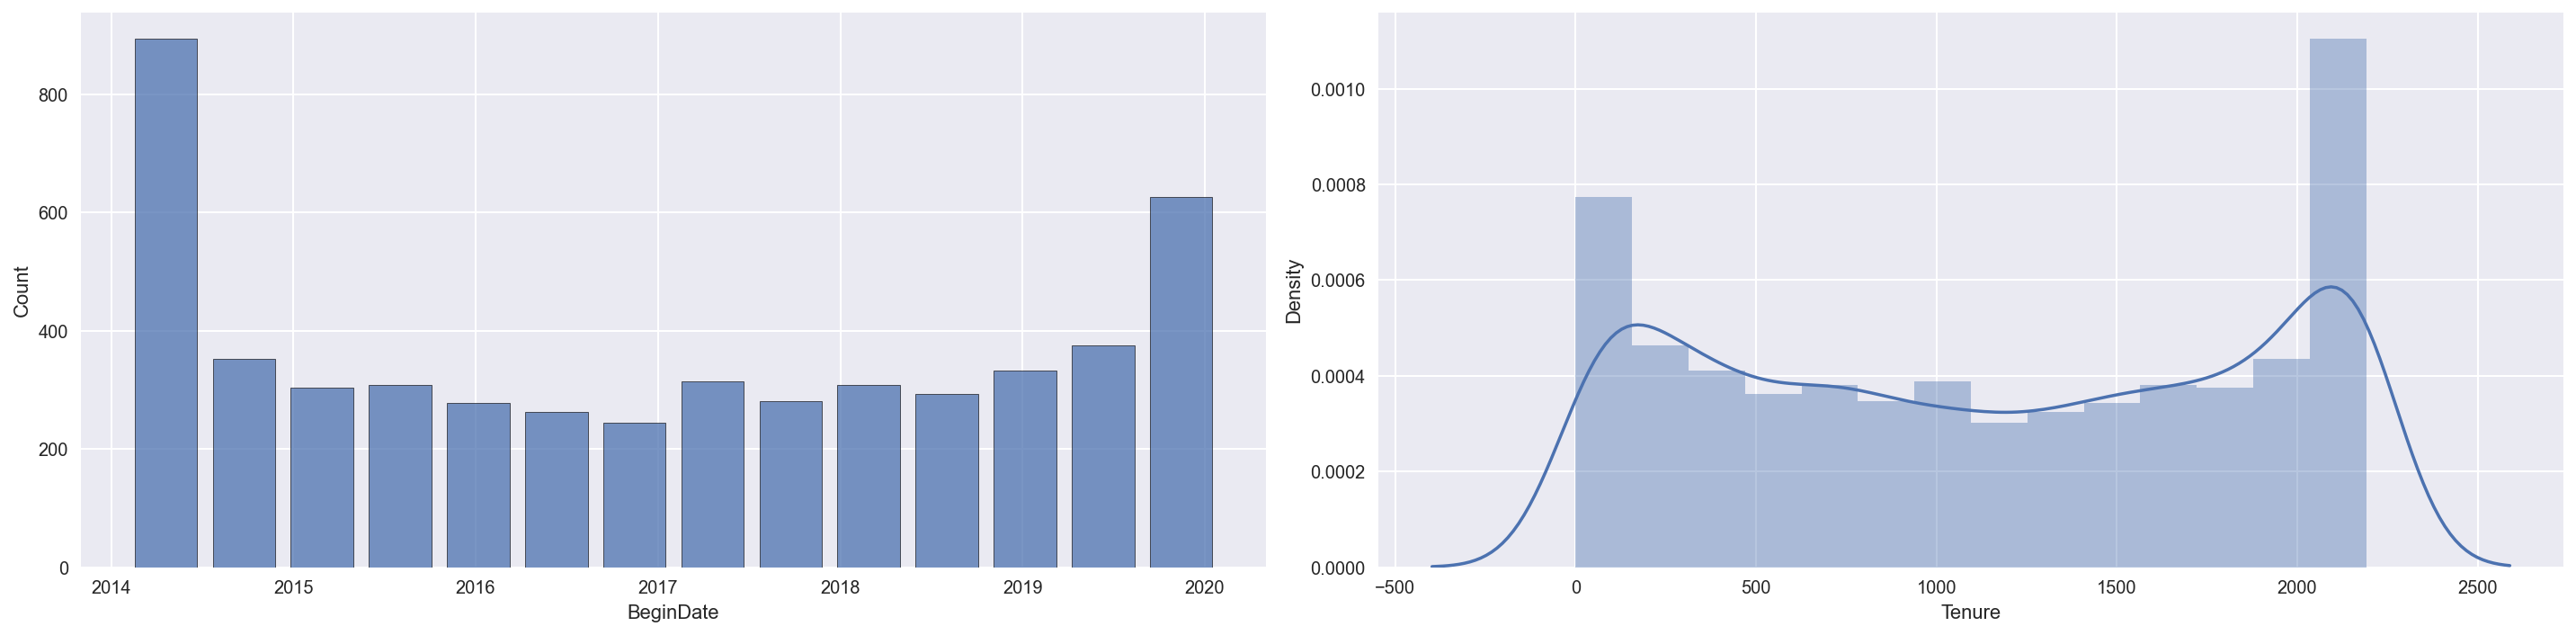

In [15]:
print('Churned customers')
fig, axs = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(churned, x='BeginDate', shrink=.8, ax=axs[0])  
sns.histplot(churned, x='EndDate', shrink=.8, ax=axs[1])      
sns.distplot(churned['Tenure'], ax=axs[2])
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()
print()
print('Non-churned customers')
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(notchurned, x='BeginDate', shrink=.8, ax=axs[0])  
sns.distplot(notchurned['Tenure'], ax=axs[1])
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()

In [16]:
contracts_joined[contracts_joined['EndDate']<'2020-02-01']['EndDate'].value_counts().sort_index()

2019-10-01    458
2019-11-01    485
2019-12-01    466
2020-01-01    460
Name: EndDate, dtype: int64

The `EndDate` values look very unrealistic. Here we have only four dates; the first is at the end of 2019. This gives us a strange distribution of the non-churned customers' tenure with a vast peak of about 2000 days.

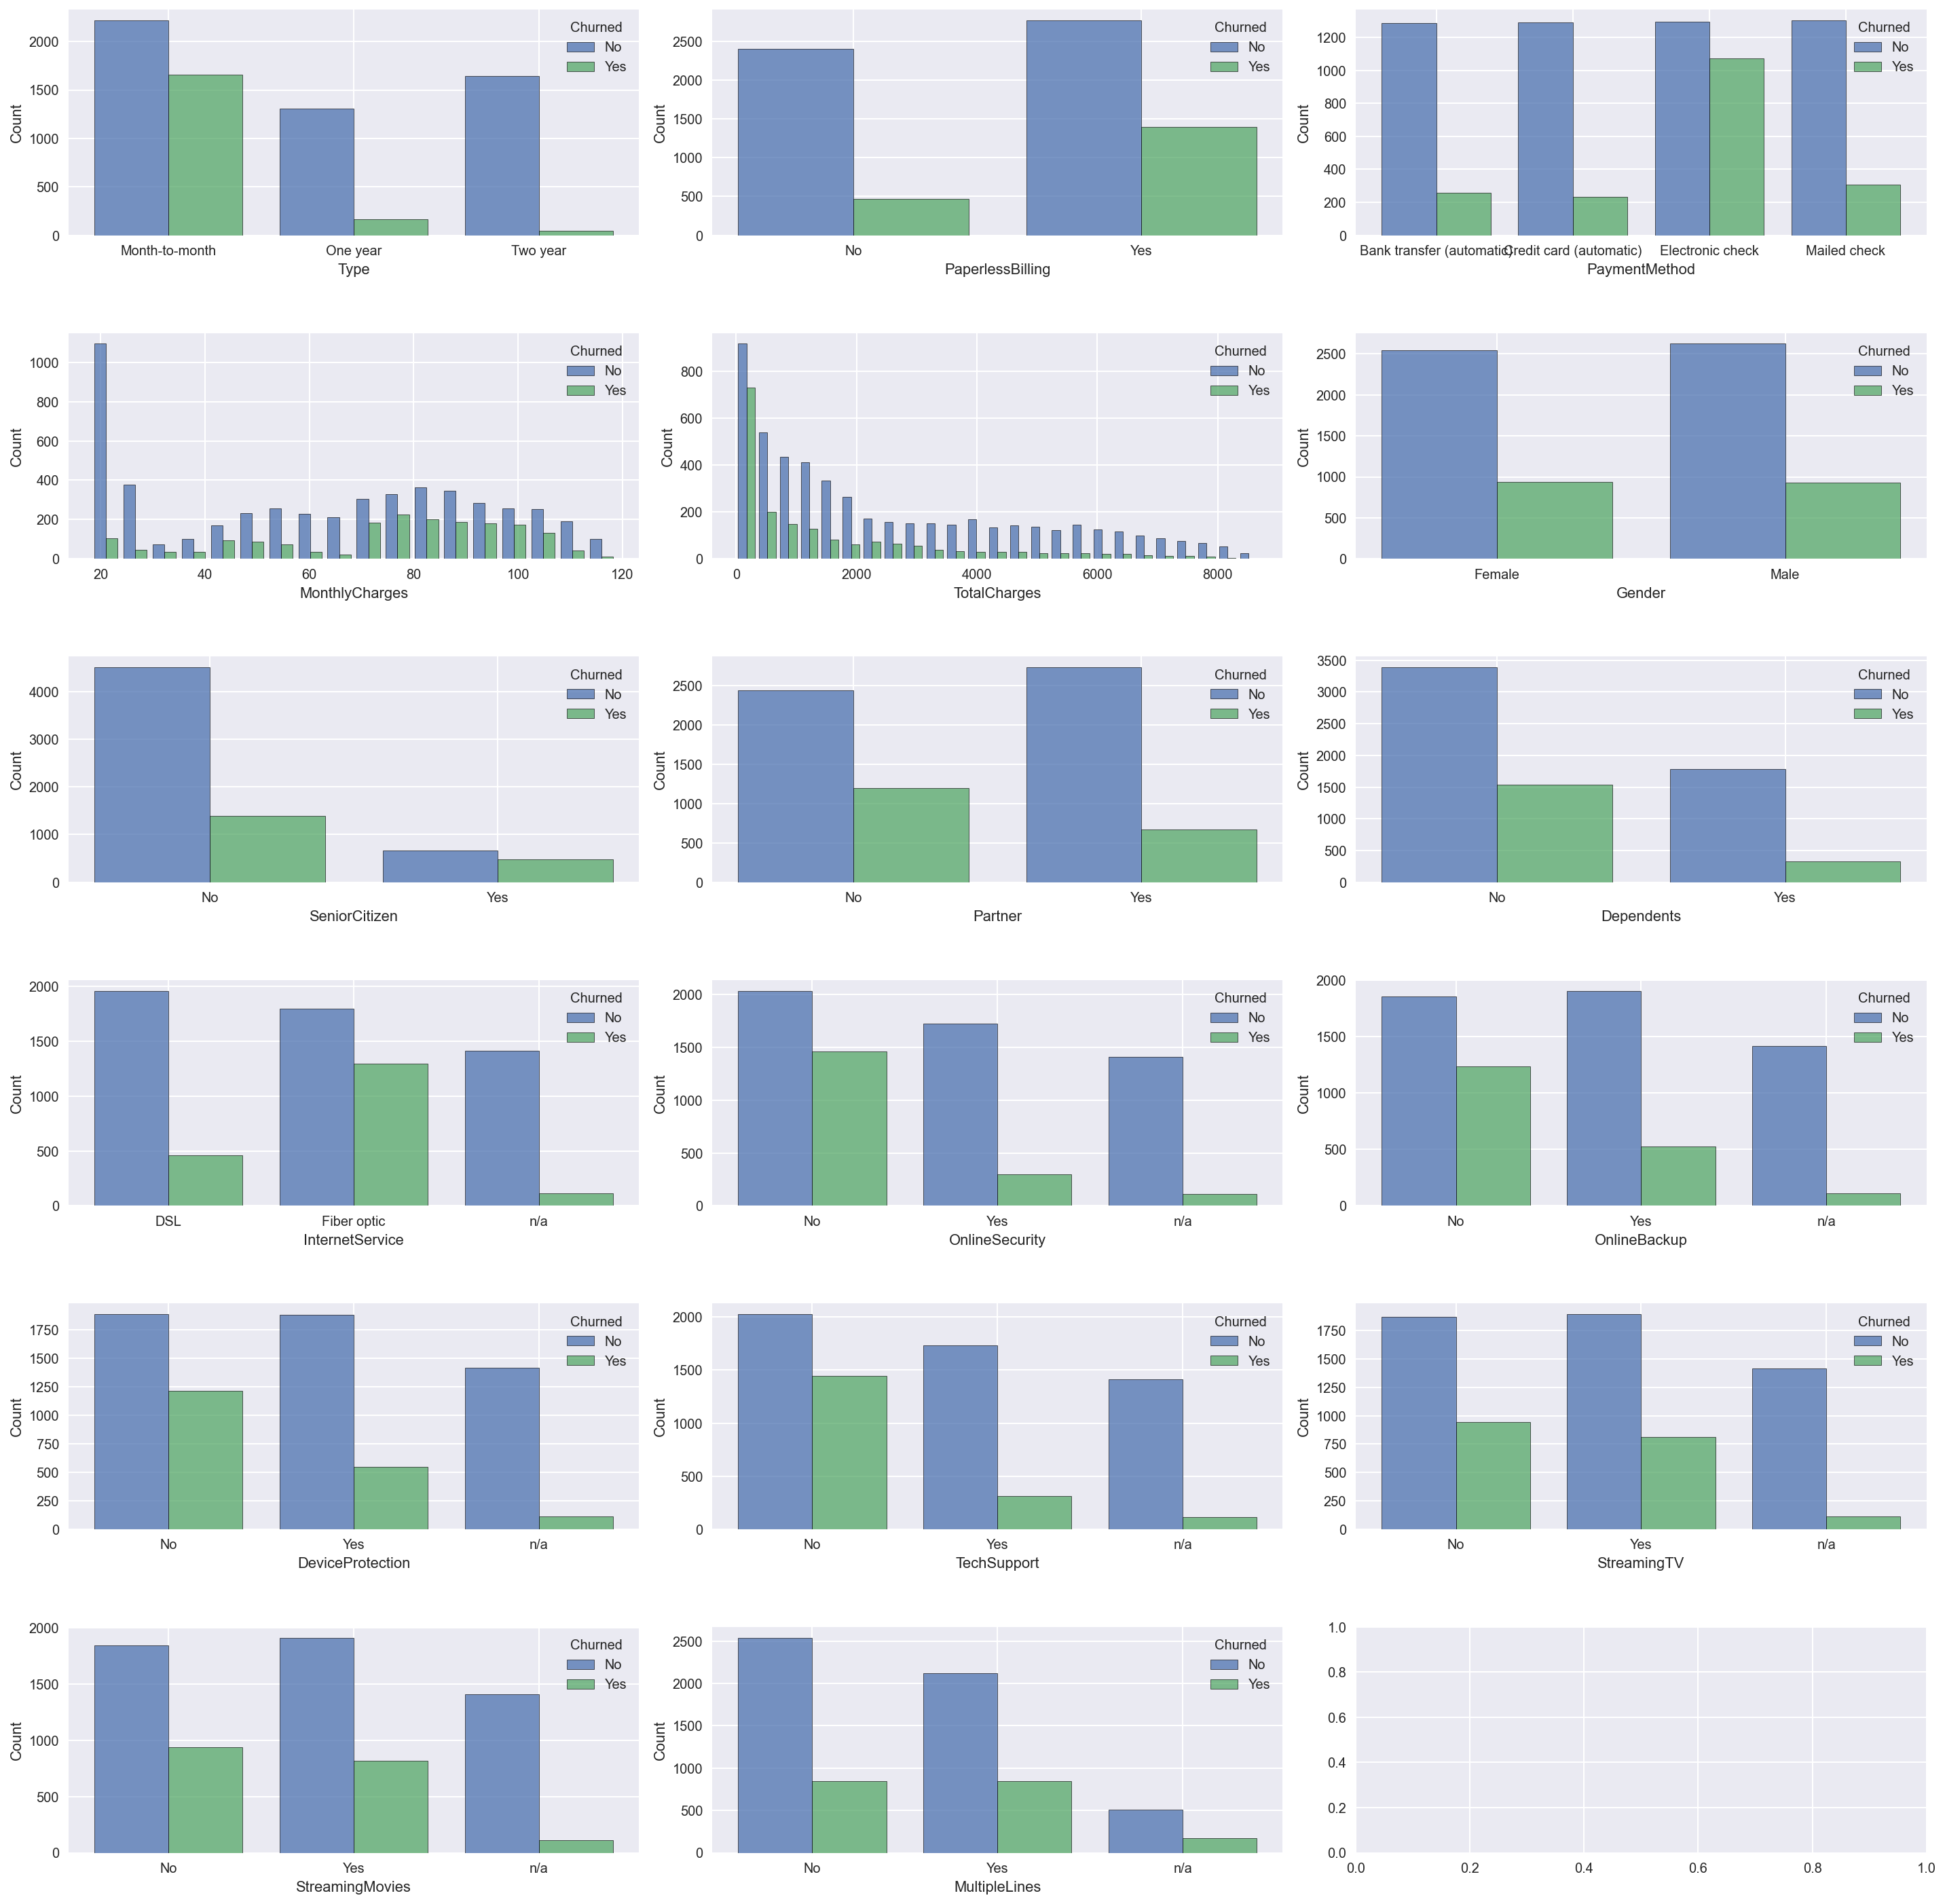

In [17]:
fig, axs = plt.subplots(6, 3, figsize=(20,20))
plt.subplots_adjust(hspace = 10);

col = 0
row = 0
for i in contracts_joined.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Tenure', 'Churned']).columns:
    sns.histplot(contracts_joined, x=i, hue='Churned',  multiple='dodge', shrink=.8, ax=axs[row, col])  
    col += 1 
    if col > 2:
        col = 0
        row += 1

plt.tight_layout()
plt.show()

**Questions:**

1. Should we drop the fresh customers or assign their `TotalCharge` to zero?
2. With such strange distribution of the `EndDate`, I'm not sure that `Tenure` could be a reliable feature. I could suggest dropping the data on the customers who joined in 2013 and 2014 (it will eliminate this suspicious peak at 2000 days of tenure, but it is ~19% of the data). Or maybe we shouldn't use `Tenure` and look at other features?
3. If I understand everything correctly, `TotalCharges` is `MonthlyCharges` multiplied by `Tenure`, so we have interdependent variables. Should we drop `TotalCharges`, or it won't confuse the model much?
4. I suppose that `Gender` could be excluded from the features as there is no difference (and I think there couldn't be any). Am I right?
5. Unfortunately, I don't get what the row "Additional metric: Accuracy." from the Clarification page in Notion mean. Should I also count the Accuracy? 

**Plan**

1. Feature Engineering (I've already done a little during the EDA, but answers to the questions above would help immensely).
2. Train/Test split.
3. Encoding the categorical variables for simple models and Scaling (Also, at this point, we could do something to address the class imbalance, but since we are using AUC-ROC as a primary metric and not accuracy, this isn't necessary).
4. Build a baseline model. In this case, it could yield 'No' with a 0.75 probability (about 1/4 of our customers have churned).
5. Build some models and cross-validate them: LogisticRegression, RandomForest (After the first training, we could extract feature importances and leave only the valuable features), CatBoostClassifier
6. Test the best model on the test set.
7. Don't get the desired AUC-ROC, so go back to step 5 and try more hyperparameters. (repeat several times)
8. Translate our findings to a coherent conclusion.

## Building Models
### Feature Engineering

In [18]:
raw_features = contracts_joined.drop(['customerID', 'BeginDate', 'EndDate', 'Churned'], axis=1)
target = contracts_joined['Churned']
raw_features.info()

X_train, X_test, y_train, y_test = train_test_split(
    raw_features, target, test_size=0.25, random_state=42
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   Gender            7043 non-null   category
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

### Baseline Model

In [19]:
dummy = DummyClassifier(strategy='stratified', random_state=42).fit(X_train, y_train)
dummy_roc_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])

print(f'ROC-AUC score of Dummy model: {dummy_roc_auc:.3f}')

ROC-AUC score of Dummy model: 0.507


### Logistic Regression

In [20]:
%%time
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_exclude='category')),
        ('cat', BinaryEncoder(), make_column_selector(dtype_include='category')),
    ]
)
pipe_lr = Pipeline([('preprocessor', preprocessor_lr), ('lr', LogisticRegression())])
lr = GridSearchCV(pipe_lr, param_grid={}, cv=5, scoring='roc_auc', verbose=0, refit=True)
lr.fit(X_train, y_train)
score = abs(lr.best_score_)
best_params = lr.best_params_

print(f'ROC-AUC score of Logistic Regression model: {score:.3f}')
print()

ROC-AUC score of Logistic Regression model: 0.841

CPU times: user 4.28 s, sys: 639 ms, total: 4.91 s
Wall time: 1.65 s


### Random Forest

In [21]:
%%time
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_exclude='category')),
        ('cat', OrdinalEncoder(), make_column_selector(dtype_include='category')),
    ]
)
pipe_rf = Pipeline([('preprocessor', preprocessor_rf), ('rf', RandomForestClassifier(random_state=42))])    
    
params_rf = {'rf__n_estimators': [5, 10, 20],
          'rf__max_depth': [3, 5, 10],
          'rf__min_impurity_decrease': [0.01, 0.05, 0.1]}

rf = GridSearchCV(pipe_rf, param_grid=params_rf, cv=5, scoring='roc_auc', verbose=0, refit=True)
rf.fit(X_train, y_train)
score = abs(rf.best_score_)
best_params = rf.best_params_

print(f'ROC-AUC score of Random Forest model: {score:.3f}')
print(f'params: {best_params}')
print()

ROC-AUC score of Random Forest model: 0.826
params: {'rf__max_depth': 5, 'rf__min_impurity_decrease': 0.01, 'rf__n_estimators': 20}

CPU times: user 18.3 s, sys: 385 ms, total: 18.7 s
Wall time: 18.4 s


### Cat Boost

In [24]:
%%time

cat_features = X_train.select_dtypes(include=['category']).columns.values
cbc = CatBoostClassifier(random_seed=42, silent=True, custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false'])
params_cb = {'iterations': [200], 
          'depth': [5, 10], 
          'learning_rate': [0.05, 0.1],}
train_pool = Pool(X_train, y_train, cat_features=cat_features)

grid_search_result = cbc.grid_search(params_cb, X=train_pool)
score = abs(cbc.get_best_score()['learn']['AUC'])
best_params = grid_search_result['params']
        
print(f'ROC-AUC score of Cat Boost model: {score:.3f}')
print(f'params: {best_params}')
print()


bestTest = 0.3811028838
bestIteration = 199

0:	loss: 0.3811029	best: 0.3811029 (0)	total: 1.12s	remaining: 3.37s

bestTest = 0.3629977049
bestIteration = 197

1:	loss: 0.3629977	best: 0.3629977 (1)	total: 2.24s	remaining: 2.24s

bestTest = 0.3870538612
bestIteration = 192

2:	loss: 0.3870539	best: 0.3629977 (1)	total: 5.71s	remaining: 1.9s

bestTest = 0.3877520941
bestIteration = 143

3:	loss: 0.3877521	best: 0.3629977 (1)	total: 9.11s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.3614940732
bestIteration = 199

Training on fold [1/3]

bestTest = 0.3646401024
bestIteration = 169

Training on fold [2/3]

bestTest = 0.3772763209
bestIteration = 199

ROC-AUC score of Cat Boost model: 0.921
params: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}

CPU times: user 1min 29s, sys: 5.09 s, total: 1min 34s
Wall time: 13.4 s


### Extracting feature importances

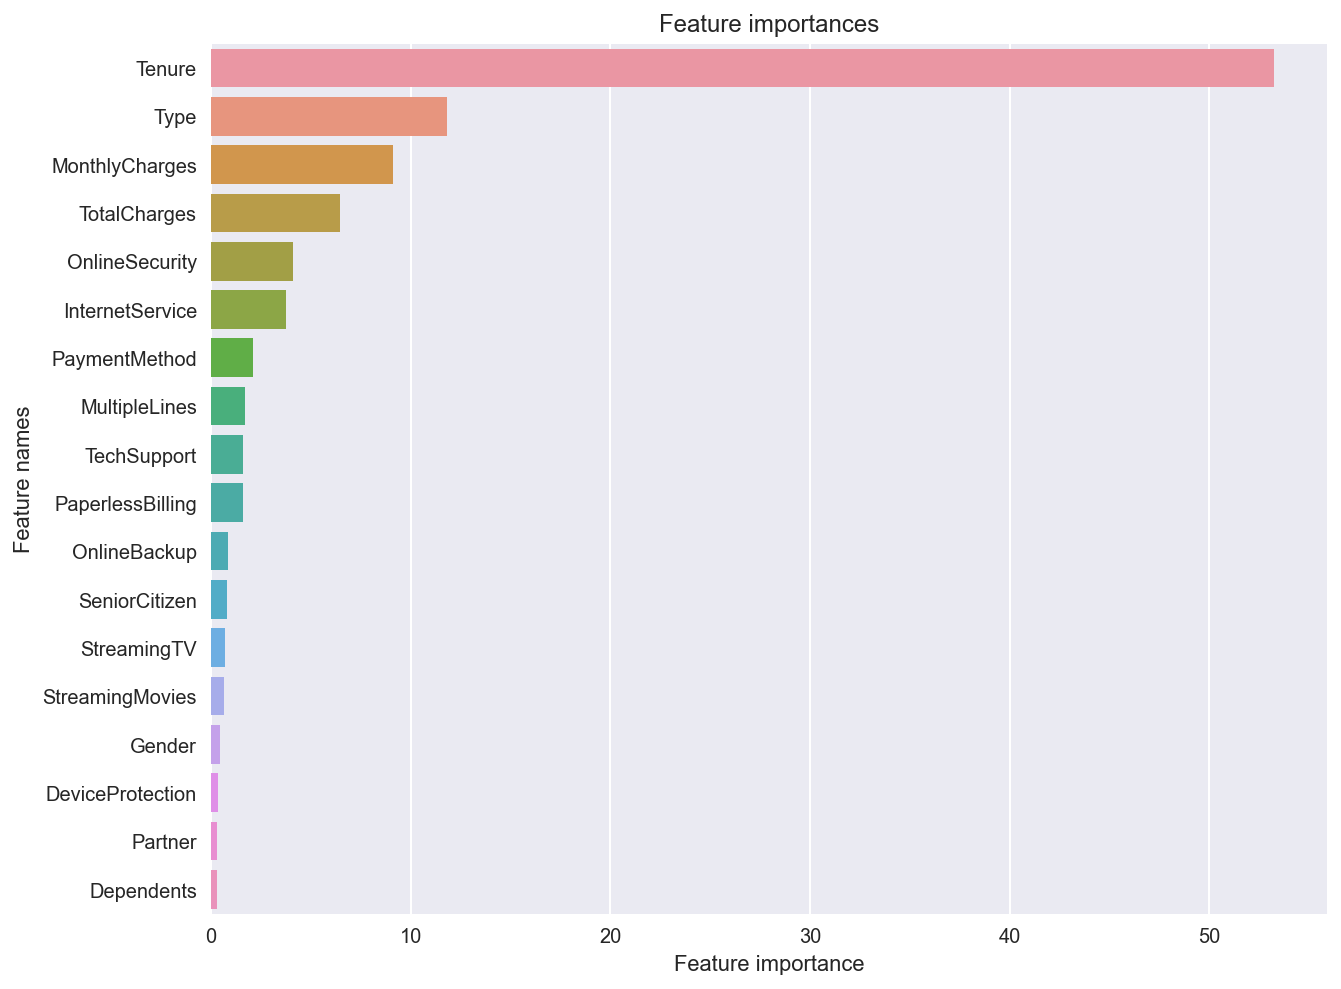

In [25]:
catboost_importances = pd.DataFrame({'feature_importance': cbc.get_feature_importance(train_pool), \
                                      'feature_names': X_train.columns}).\
                                    sort_values(by=['feature_importance'], ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=catboost_importances['feature_importance'], y=catboost_importances['feature_names'])
plt.title('Feature importances')
plt.xlabel('Feature importance')
plt.ylabel('Feature names')
plt.show()

Based on feature importances, we could exclude `Gender`, `SeniorCitizen`, `Partner`, `Dependents`, `OnlineBackup`, `DeviceProtection`, `StreamingTV` and `StreamingMovies` features as they don't add substantial value to the model.

In [26]:
X_train_1 = X_train.drop(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineBackup', \
                          'DeviceProtection', 'StreamingTV', 'StreamingMovies'], axis=1)                          
X_test_1 = X_test.drop(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineBackup', \
                          'DeviceProtection', 'StreamingTV', 'StreamingMovies'], axis=1) 

In [27]:
%%time

cat_features = X_train_1.select_dtypes(include=['category']).columns.values
cbc_2 = CatBoostClassifier(random_seed=42, silent=True, custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false'])
params_cb = {'iterations': [200], 
          'depth': [5, 10], 
          'learning_rate': [0.05, 0.1],}
train_pool = Pool(X_train_1, y_train, cat_features=cat_features)

grid_search_result = cbc_2.grid_search(params_cb, X=train_pool)
score = abs(cbc_2.get_best_score()['learn']['AUC'])
best_params = grid_search_result['params']
        
print(f'ROC-AUC score of Cat Boost model: {score:.3f}')
print(f'params: {best_params}')
print()


bestTest = 0.3809836042
bestIteration = 194

0:	loss: 0.3809836	best: 0.3809836 (0)	total: 976ms	remaining: 2.93s

bestTest = 0.3566558367
bestIteration = 197

1:	loss: 0.3566558	best: 0.3566558 (1)	total: 2.29s	remaining: 2.29s

bestTest = 0.3802731221
bestIteration = 199

2:	loss: 0.3802731	best: 0.3566558 (1)	total: 4.42s	remaining: 1.47s

bestTest = 0.3687941397
bestIteration = 198

3:	loss: 0.3687941	best: 0.3566558 (1)	total: 7.08s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.3620510458
bestIteration = 195

Training on fold [1/3]

bestTest = 0.3586819353
bestIteration = 199

Training on fold [2/3]

bestTest = 0.3660028
bestIteration = 189

ROC-AUC score of Cat Boost model: 0.924
params: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}

CPU times: user 1min 5s, sys: 4.93 s, total: 1min 10s
Wall time: 10.5 s


**Conclusion**  
Excluding the features of minor importance, we haven't lowered the model's ROC-AUC score but improved the training time.

### Testing the best model

In [28]:
cat_features = X_train_1.select_dtypes(include=['category']).columns.values

cbc_final = CatBoostClassifier(random_seed=42, silent=True, \
                                custom_metric=['Logloss', 'AUC:hints=skip_train~false'], \
                                depth = 5, iterations = 200, 
                                learning_rate = 0.1)

cbc_final.fit(X=Pool(X_train_1, y_train, cat_features=cat_features))

cb_roc_auc = roc_auc_score(y_test, cbc_final.predict_proba(X_test_1)[:, 1])

print(f'ROC-AUC score for best CatBoostClassifier model on the test data: {cb_roc_auc:.2f}')

ROC-AUC score for best CatBoostClassifier model on the test data: 0.91


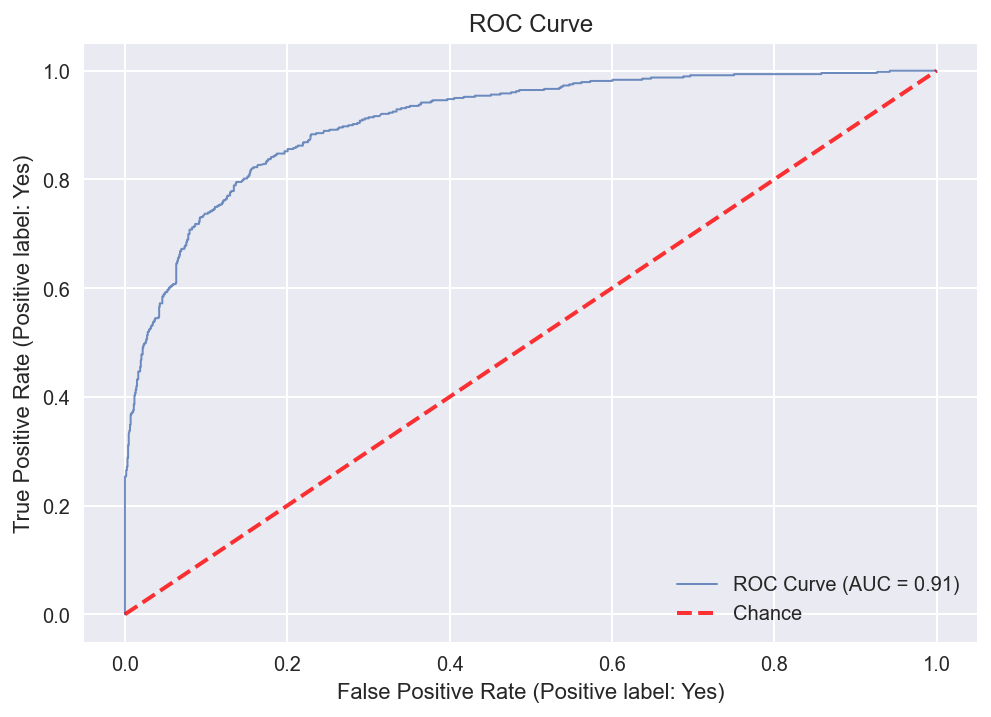

In [29]:
fig, ax = plt.subplots()
rfc_disp = plot_roc_curve(cbc_final, X_test_1, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve")
ax.legend(loc="lower right")
plt.show()

Accuracy: 0.851
Precision: 0.824
Recall: 0.576
Specificity: 0.954


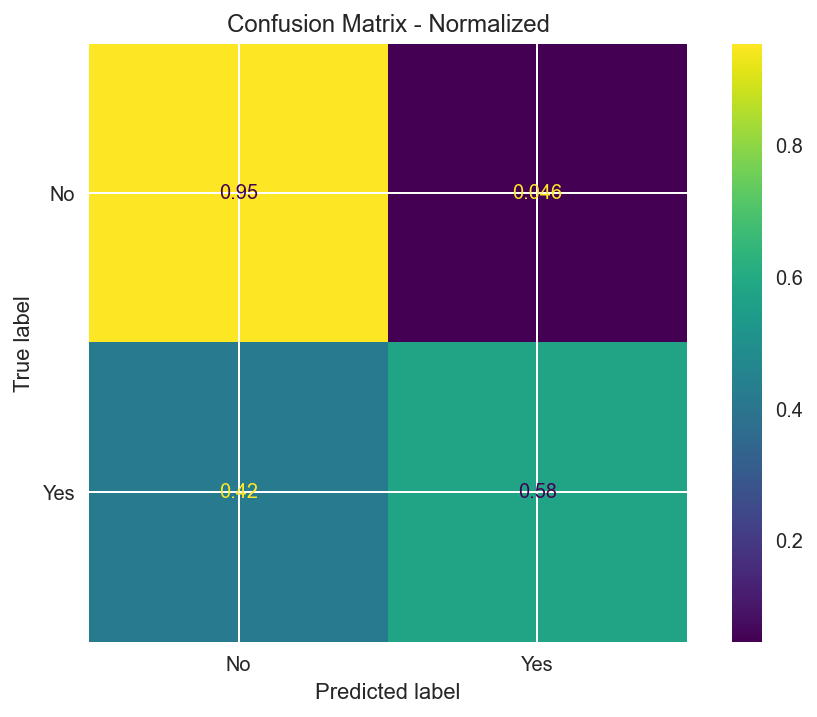

In [30]:
test_predict = cbc_final.predict(X_test_1)
rf_matrix = confusion_matrix(y_test, test_predict)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / \
            (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {percision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'Specificity: {specificity:.3f}')

disp = plot_confusion_matrix(cbc_final, X_test_1, y_test, display_labels=['No', 'Yes'], normalize='true')
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

### Conclusion 
In this project, we explored some information about telecom clients. We aimed to predict if the client could churn based on their plans and contact information.   
After exploring the data and extracting valuable features, we trained several different models. Extracting feature importance from the CatBoost model allowed us to exclude eight features that didn't decrease the impurity so our final model could train and predict faster.   
Our best model is **CatBoostClassifier** with a ROC-AUC score on the test data of 0.91.